In [1]:
"""
04_model_training_and_evaluation.ipynb

Comprehensive model training workflow for electricity price forecasting.
Models: LightGBM, XGBoost, Prophet, Hybrid CNN-LSTM (Keras, custom loss).

Author: [Your Name]
Date: 2025-11-02
"""
# %% Setup and Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import xgboost as xgb
from prophet import Prophet
from tensorflow.keras import layers, models, callbacks, optimizers
import tensorflow as tf
import gc, warnings
warnings.filterwarnings('ignore')

# Load feature data
df = pd.read_csv('data/processed/electricity_prices_features.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

target_col = 'price_eur_mwh'
timestamp_col = 'timestamp'
feature_cols = [c for c in df.columns if c not in [target_col, timestamp_col]]

# Train/validation/test split (no shuffle, sequential)
split1 = int(len(df)*0.7)
split2 = int(len(df)*0.85)

train = df.iloc[:split1]
val = df.iloc[split1:split2]
test = df.iloc[split2:]

print(f"Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")


Train: (66256, 80), Val: (14198, 80), Test: (14198, 80)


In [2]:
print(train[feature_cols].dtypes.value_counts())
print(train[feature_cols].describe())
print("Any NaN left?", train[feature_cols].isna().sum().sum())


float64    59
int64      17
bool        2
Name: count, dtype: int64
               year         month           day          hour     dayofweek  \
count  66256.000000  66256.000000  66256.000000  66256.000000  66256.000000   
mean    2018.312847      6.343999     15.748008     11.499034      3.000845   
std        2.192086      3.420191      8.784830      6.922053      1.999381   
min     2015.000000      1.000000      1.000000      0.000000      0.000000   
25%     2016.000000      3.000000      8.000000      5.000000      1.000000   
50%     2018.000000      6.000000     16.000000     11.000000      3.000000   
75%     2020.000000      9.000000     23.000000     17.000000      5.000000   
max     2022.000000     12.000000     31.000000     23.000000      6.000000   

          dayofyear          week    is_holiday    is_weekend  price_lag_1h  \
count  66256.000000  66256.000000  66256.000000  66256.000000  66256.000000   
mean     177.697899     25.887225      0.007607      0.285680 

In [17]:
# 1) Replace any remaining ±Inf → NaN
for frame in (train, val, test):
    frame.replace([np.inf, -np.inf], np.nan, inplace=True)  # pandas way
    # 2) Coerce non-numerics to NaN (safety)
    frame[feature_cols] = frame[feature_cols].apply(pd.to_numeric, errors="coerce")

# 3) Impute or drop NaNs
train[feature_cols] = train[feature_cols].fillna(train[feature_cols].median())
val[feature_cols]   = val[feature_cols].fillna(train[feature_cols].median())
test[feature_cols]  = test[feature_cols].fillna(train[feature_cols].median())

# 4) Final finite scan (fail-fast if anything remains)
def assert_all_finite(df, cols):
    X = df[cols].to_numpy(dtype=float, copy=False)
    if not np.isfinite(X).all():
        raise ValueError("Found non-finite or too-large values after cleaning.")
assert_all_finite(train, feature_cols)
assert_all_finite(val, feature_cols)
assert_all_finite(test, feature_cols)


In [ ]:

def clean_inf_nan(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median(numeric_only=True))
    return df

train = clean_inf_nan(train)
val = clean_inf_nan(val)
test = clean_inf_nan(test)

# Ensure all columns are numeric
train = train.apply(pd.to_numeric, errors='coerce')
val = val.apply(pd.to_numeric, errors='coerce')
test = test.apply(pd.to_numeric, errors='coerce')

# Confirm there are no infinities left
print("Any inf values in train?", np.isinf(train[feature_cols]).to_numpy().any())
print("Any NaN values in train?", train[feature_cols].isna().any().any())

In [29]:
# %% LightGBM Model

print("Training LightGBM...")

lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_data_in_leaf=20,
    feature_fraction=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    force_col_wise=True,
)

lgb_model.fit(
    train[feature_cols],
    train[target_col],
    eval_set=[(val[feature_cols], val[target_col])],
    eval_metric='mae',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

val_pred_lgb = lgb_model.predict(val[feature_cols])
test_pred_lgb = lgb_model.predict(test[feature_cols])

print("LightGBM MAE:", mean_absolute_error(test[target_col], test_pred_lgb))


Training LightGBM...
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 14160
[LightGBM] [Info] Number of data points in the train set: 66256, number of used features: 78
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Start training from score 55.775476
Training until validation scores don't improve for 50 round

In [7]:
# %% XGBoost Model

print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=800, 
    max_depth=5, 
    learning_rate=0.18,
    subsample=0.8, 
    colsample_bytree=0.8, 
    reg_alpha=0.1, 
    reg_lambda=0.1,
    eval_metric='mae',           # Move here
    early_stopping_rounds=50     # Move here
)

xgb_model.fit(
    train[feature_cols], 
    train[target_col],
    eval_set=[(val[feature_cols], val[target_col])],
    verbose=50
)

test_pred_xgb = xgb_model.predict(test[feature_cols])
print("XGBoost MAE:", mean_absolute_error(test[target_col], test_pred_xgb))

Training XGBoost...
[0]	validation_0-mae:77.90373
[50]	validation_0-mae:6.94519
[100]	validation_0-mae:6.76790
[150]	validation_0-mae:6.63779
[200]	validation_0-mae:6.58452
[250]	validation_0-mae:6.53527
[300]	validation_0-mae:6.48802
[350]	validation_0-mae:6.46543
[400]	validation_0-mae:6.41504
[450]	validation_0-mae:6.38921
[500]	validation_0-mae:6.38487
[550]	validation_0-mae:6.37643
[600]	validation_0-mae:6.36775
[650]	validation_0-mae:6.35594
[700]	validation_0-mae:6.34445
[750]	validation_0-mae:6.33945
[799]	validation_0-mae:6.33733
XGBoost MAE: 2.057100084033625


In [9]:
# %% Prophet Model (optional, univariate baseline)

print("Training Prophet...")
prophet_df = pd.DataFrame({'ds': df[timestamp_col], 'y': df[target_col]})
prophet_m = Prophet(yearly_seasonality='auto', daily_seasonality='auto', weekly_seasonality='auto')
prophet_m.fit(prophet_df.iloc[:split1+split2//2])
future = prophet_m.make_future_dataframe(periods=len(test), freq='H')
forecast = prophet_m.predict(future)
test_pred_prophet = forecast['yhat'].iloc[-len(test):].values
print("Prophet MAE:", mean_absolute_error(test[target_col], test_pred_prophet))


Training Prophet...


01:07:34 - cmdstanpy - INFO - Chain [1] start processing
01:09:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 39.911509674406425


In [11]:
# 0) Choose features (ensure strictly numeric columns)
sel_features = feature_cols[:N_FEATURES]  # keep consistent across splits

# 1) Coerce to numeric and replace ±Inf -> NaN
for df_ in (train, val, test):
    df_[sel_features] = df_[sel_features].apply(pd.to_numeric, errors="coerce")  # non-numerics -> NaN
    df_[target_col] = pd.to_numeric(df_[target_col], errors="coerce")            # ensure numeric target
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)                         # ±Inf -> NaN
# Recheck that only finite values remain after imputation later

# 2) Simple imputation (median from train), or use a scaler pipeline if desired
med = train[sel_features].median()
for df_ in (train, val, test):
    df_[sel_features] = df_[sel_features].fillna(med)
    df_[target_col] = df_[target_col].fillna(train[target_col].median())

# 3) Create sequences (unchanged)
X_train, y_train = create_sequences(train, sel_features, target_col)
X_val,   y_val   = create_sequences(val,   sel_features, target_col)
X_test,  y_test  = create_sequences(test,  sel_features, target_col)

# 4) Enforce numeric dtypes and finiteness for Keras
def to_float32_and_check(X, y):
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    if not np.isfinite(X).all() or not np.isfinite(y).all():
        raise ValueError("Found non-finite values in DL tensors; clean data first.")
    return X, y

X_train, y_train = to_float32_and_check(X_train, y_train)
X_val,   y_val   = to_float32_and_check(X_val,   y_val)
X_test,  y_test  = to_float32_and_check(X_test,  y_test)

print("DL shapes:", X_train.shape, y_train.shape, X_train.dtype, y_train.dtype)
# Expect float32 tensors with finite values; np.isfinite is the canonical check.


DL shapes: (66065, 168, 35) (66065, 24) float32 float32


In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)  # expect (N, 168, F) and (N, 24) 
print(X_train.dtype, y_train.dtype, X_val.dtype, y_val.dtype)   # must be float32/float64, not object 
import numpy as np
print(np.isfinite(X_train).all(), np.isfinite(y_train).all())    # must be True
print(np.isfinite(X_val).all(), np.isfinite(y_val).all())        # must be True


In [21]:
sel_features = feature_cols[:N_FEATURES]  # ensure strictly numeric columns 

for df_ in (train, val, test):
    df_[sel_features] = df_[sel_features].apply(pd.to_numeric, errors="coerce")  # strings -> NaN 
    df_[target_col] = pd.to_numeric(df_[target_col], errors="coerce")            # numeric y 
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)                         # ±Inf -> NaN

med_X = train[sel_features].median()
med_y = train[target_col].median()
for df_ in (train, val, test):
    df_[sel_features] = df_[sel_features].fillna(med_X)                          # impute X
    df_[target_col] = df_[target_col].fillna(med_y)                              # impute y 


In [22]:
def create_sequences_np(df, features, target, seq_len=168, horizon=24):
    X_src = df[features].to_numpy(dtype=np.float32, copy=True)  # numeric float32 
    y_src = df[target].to_numpy(dtype=np.float32, copy=True)    # numeric float32 
    n = len(df) - seq_len - horizon + 1
    if n <= 0:
        raise ValueError("Not enough rows to build sequences")  # guard 
    X = np.empty((n, seq_len, X_src.shape[1]), dtype=np.float32)  # preallocate 
    y = np.empty((n, horizon), dtype=np.float32)                   # preallocate 
    for i in range(n):
        X[i] = X_src[i:i+seq_len]
        y[i] = y_src[i+seq_len:i+seq_len+horizon]
    if not np.isfinite(X).all() or not np.isfinite(y).all():
        raise ValueError("Sequences contain non-finite values; clean data first")
    return X, y

X_train, y_train = create_sequences_np(train, sel_features, target_col, SEQ_LEN, 24)  # float32 tensors 
X_val,   y_val   = create_sequences_np(val,   sel_features, target_col, SEQ_LEN, 24)  # float32 tensors 
X_test,  y_test  = create_sequences_np(test,  sel_features, target_col, SEQ_LEN, 24)  # float32 tensors 


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

tf.keras.backend.set_floatx('float32')  # default float type 

def custom_price_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)   # enforce float32 
    y_pred = tf.cast(y_pred, tf.float32)   # enforce float32 
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # MSE 
    zero = tf.constant(0.0, tf.float32)  # spike penalty 
    spike_penalty = tf.reduce_mean(tf.maximum(zero, (y_true - 100.0) * (y_pred - 100.0)))  
    dy_true = y_true[:, 1:] - y_true[:, :-1]  # diff along time axis 
    dy_pred = y_pred[:, 1:] - y_pred[:, :-1]  # diff along time axis 
    direction_penalty = tf.reduce_mean(tf.abs(tf.sign(dy_true) - tf.sign(dy_pred)))  
    smoothness_penalty = tf.reduce_mean(tf.square(dy_pred))  
    return mse_loss + 0.3 * spike_penalty + 0.2 * direction_penalty + 0.1 * smoothness_penalty  

def build_cnn_lstm_model(sequence_length=SEQ_LEN, n_features=N_FEATURES):
    inputs = layers.Input(shape=(sequence_length, n_features), dtype='float32')  # enforce float32 
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)  
    x = layers.MaxPooling1D(2)(x)  
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)  
    x = layers.MaxPooling1D(2)(x)  
    x = layers.LSTM(128, return_sequences=True)(x)  
    x = layers.Dropout(0.2)(x)  
    x = layers.LSTM(64, return_sequences=False)(x)  
    x = layers.Dropout(0.2)(x)  
    x = layers.Dense(128, activation='relu')(x)  
    x = layers.Dense(64, activation='relu')(x)  
    outputs = layers.Dense(24, activation='linear', dtype='float32')(x)  # float32 
    return models.Model(inputs=inputs, outputs=outputs)  

model = build_cnn_lstm_model(sequence_length=SEQ_LEN, n_features=N_FEATURES)
model.compile(optimizer=optimizers.Adam(1e-3),
              loss=custom_price_loss,
              metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [24]:
for arr in (X_train, y_train, X_val, y_val):
    assert arr.dtype == np.float32 and np.isfinite(arr).all(), "Bad dtype/values before fit"

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=32,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=2
)


Epoch 1/50
2065/2065 - 117s - 57ms/step - loss: 2863.5959 - mean_absolute_error: 23.4056 - val_loss: 8894.6172 - val_mean_absolute_error: 52.5831
Epoch 2/50
2065/2065 - 125s - 61ms/step - loss: 2628.1401 - mean_absolute_error: 22.5473 - val_loss: 9936.8438 - val_mean_absolute_error: 63.5478
Epoch 3/50
2065/2065 - 128s - 62ms/step - loss: 3285.7009 - mean_absolute_error: 28.7510 - val_loss: 9990.8779 - val_mean_absolute_error: 53.5606
Epoch 4/50
2065/2065 - 128s - 62ms/step - loss: 2639.9336 - mean_absolute_error: 22.2169 - val_loss: 12409.8955 - val_mean_absolute_error: 67.6626
Epoch 5/50
2065/2065 - 133s - 64ms/step - loss: 2520.5469 - mean_absolute_error: 21.1128 - val_loss: 8632.6230 - val_mean_absolute_error: 49.1825
Epoch 6/50
2065/2065 - 114s - 55ms/step - loss: 2576.8506 - mean_absolute_error: 21.2335 - val_loss: 10942.7529 - val_mean_absolute_error: 55.3069
Epoch 7/50
2065/2065 - 113s - 55ms/step - loss: 2531.6526 - mean_absolute_error: 21.2013 - val_loss: 11927.8564 - val_mean

In [27]:
test_pred_cnn_lstm = cnn_lstm_model.predict(X_test).astype(np.float32)
print("CNN-LSTM MAE (mean over 24h window):", mean_absolute_error(y_test.flatten(), test_pred_cnn_lstm.flatten()))

438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step
CNN-LSTM MAE (mean over 24h window): 85.857475


In [31]:
from pathlib import Path
import joblib

# choose a consistent models folder (align with your config if you have one)
models_dir = Path("models")  # or Path("data/models")
models_dir.mkdir(parents=True, exist_ok=True)  # creates parents if missing

# build absolute file paths
lgb_path = models_dir / "lightgbm_model.pkl"
xgb_path = models_dir / "xgboost_model.pkl"
dl_path  = models_dir / "cnn_lstm_model.keras"

# save artifacts
joblib.dump(lgb_model, lgb_path)      # OK after mkdir
joblib.dump(xgb_model, xgb_path)      # OK after mkdir
cnn_lstm_model.save(dl_path)          # Keras model save
print(f"Saved to: {lgb_path}, {xgb_path}, {dl_path}")


Saved to: models\lightgbm_model.pkl, models\xgboost_model.pkl, models\cnn_lstm_model.keras


      Model   Test MAE  Test RMSE   Test R2
0  LightGBM   1.835466   4.256380  0.993398
1   XGBoost   2.057100   4.663709  0.992073
2   Prophet  39.911510  55.481808 -0.121818
3  CNN-LSTM  85.857475  99.318726 -2.559426
Models saved!


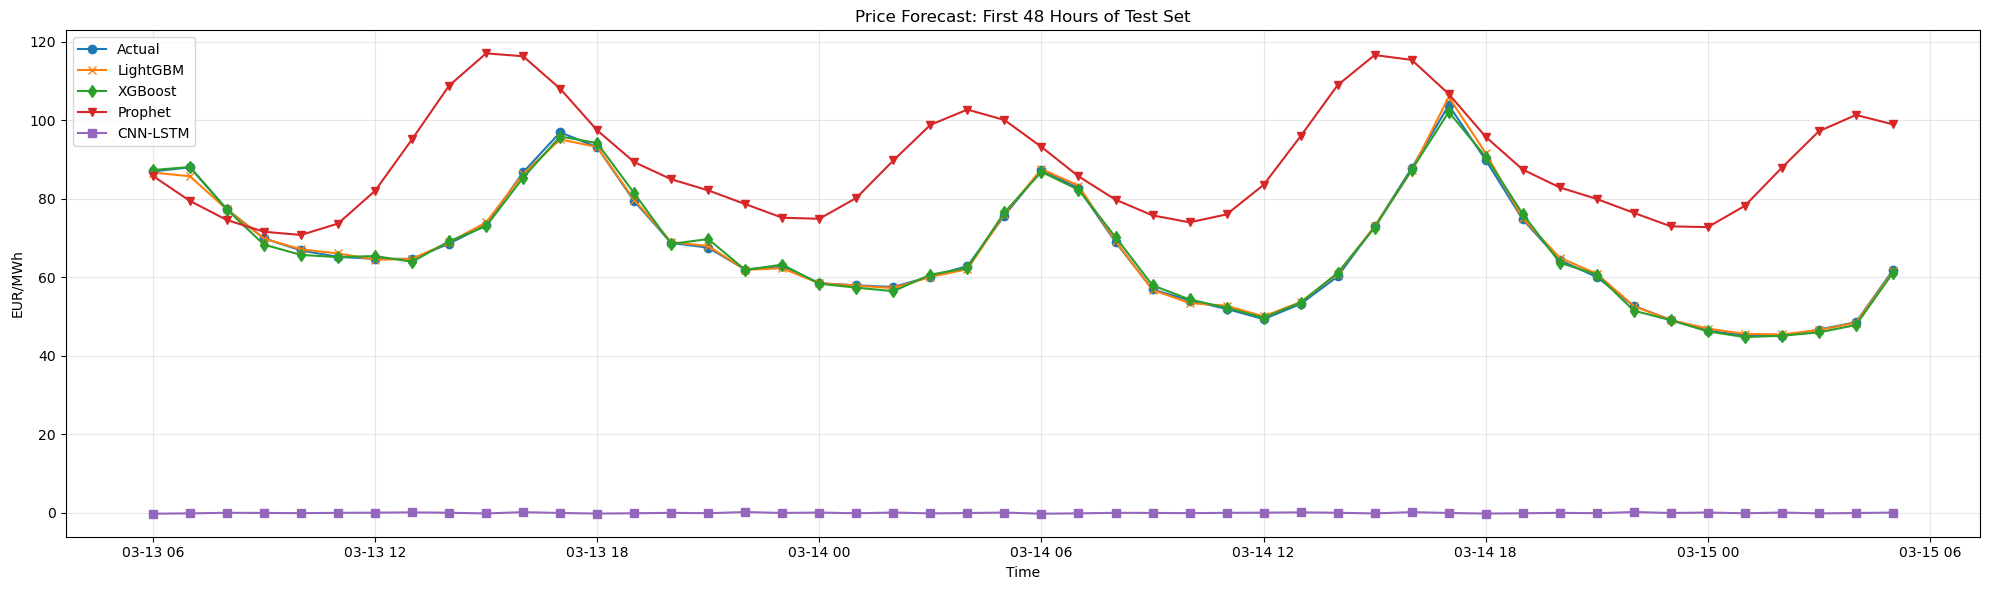

Model training and evaluation complete!
Results:
      Model   Test MAE  Test RMSE   Test R2
0  LightGBM   1.835466   4.256380  0.993398
1   XGBoost   2.057100   4.663709  0.992073
2   Prophet  39.911510  55.481808 -0.121818
3  CNN-LSTM  85.857475  99.318726 -2.559426
Ready for: 05_optimization.ipynb


In [32]:
# %% Model Comparison Table

results = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'Prophet', 'CNN-LSTM'],
    'Test MAE': [mean_absolute_error(test[target_col], test_pred_lgb),
                 mean_absolute_error(test[target_col], test_pred_xgb),
                 mean_absolute_error(test[target_col], test_pred_prophet),
                 mean_absolute_error(y_test.flatten(), test_pred_cnn_lstm.flatten())],
    'Test RMSE': [np.sqrt(mean_squared_error(test[target_col], test_pred_lgb)),
                  np.sqrt(mean_squared_error(test[target_col], test_pred_xgb)),
                  np.sqrt(mean_squared_error(test[target_col], test_pred_prophet)),
                  np.sqrt(mean_squared_error(y_test.flatten(), test_pred_cnn_lstm.flatten()))],
    'Test R2': [r2_score(test[target_col], test_pred_lgb),
                r2_score(test[target_col], test_pred_xgb),
                r2_score(test[target_col], test_pred_prophet),
                r2_score(y_test.flatten(), test_pred_cnn_lstm.flatten())]
})

print(results)

# %% Save models (LightGBM, XGBoost, CNN-LSTM)

joblib.dump(lgb_model, 'models/lightgbm_model.pkl')
joblib.dump(xgb_model, 'models/xgboost_model.pkl')
cnn_lstm_model.save('models/cnn_lstm_model.keras')
print("Models saved!")

# %% Visualise predictions vs. actual

plt.figure(figsize=(20, 6))
plt.plot(test[timestamp_col].values[:48], test[target_col].values[:48], label='Actual', marker='o')
plt.plot(test[timestamp_col].values[:48], test_pred_lgb[:48], label='LightGBM', marker='x')
plt.plot(test[timestamp_col].values[:48], test_pred_xgb[:48], label='XGBoost', marker='d')
plt.plot(test[timestamp_col].values[:48], test_pred_prophet[:48], label='Prophet', marker='v')
plt.plot(test[timestamp_col].values[:48], test_pred_cnn_lstm.flatten()[:48], label='CNN-LSTM', marker='s')
plt.legend()
plt.title('Price Forecast: First 48 Hours of Test Set')
plt.xlabel('Time')
plt.ylabel('EUR/MWh')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('data/processed/04_model_predictions.png')
plt.show()

# %% Summary

print("Model training and evaluation complete!\nResults:")
print(results)
print("Ready for: 05_optimization.ipynb")


In [ ]:
nonfinite_cols = train[feature_cols].columns[~np.isfinite(X).all(axis=0)]
print("Columns with NaN/±Inf:", list(nonfinite_cols))

In [ ]:
bad_mask = ~np.isfinite(X)
bad_rows, bad_cols = np.where(bad_mask)
print("First 10 bad cells (row, col):", list(zip(bad_rows[:10], train[feature_cols].columns[bad_cols[:10]])))


In [ ]:
f32_max = np.finfo(np.float32).max
too_large_mask = np.abs(X) > f32_max
rows_lg, cols_lg = np.where(too_large_mask)
print("Cols with >float32:", set(train[feature_cols].columns[cols_lg]))


In [14]:
import numpy as np
import pandas as pd

def scan_nonfinite_and_large(df: pd.DataFrame,
                             cols=None,
                             large_thresh: float | None = None,
                             check_float32: bool = True,
                             max_examples: int = 20):
    """
    Report NaN, +Inf, -Inf, and very large magnitudes in a DataFrame.
    - Coerces all specified columns to numeric (errors='coerce').
    - Flags values > float32 max (common limit for tree libs).
    """
    # Choose columns
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    X = df[cols].copy()

    # Coerce everything to numeric floats (strings -> NaN)
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    X_np = X.to_numpy(dtype=np.float64)  # ensure numeric matrix

    # Masks
    mask_nan = np.isnan(X_np)
    mask_posinf = np.isposinf(X_np)
    mask_neginf = np.isneginf(X_np)
    mask_nonfinite = ~np.isfinite(X_np)

    # Thresholds for "too large"
    f32_max = np.finfo(np.float32).max if check_float32 else np.inf
    mask_too_large_f32 = (np.abs(X_np) > f32_max) if check_float32 else np.zeros_like(X_np, dtype=bool)

    # Optional custom very-large threshold (fallback to high percentile)
    if large_thresh is None:
        finite_vals = X_np[np.isfinite(X_np)]
        large_thresh = (np.percentile(np.abs(finite_vals), 99.999)
                        if finite_vals.size else f32_max)
    mask_very_large = np.abs(X_np) > large_thresh

    # Summaries
    summary = pd.DataFrame({
        "nan": mask_nan.sum(axis=0),
        "+inf": mask_posinf.sum(axis=0),
        "-inf": mask_neginf.sum(axis=0),
        "non_finite_total": mask_nonfinite.sum(axis=0),
        ">float32_max": mask_too_large_f32.sum(axis=0),
        f">{large_thresh:.3g}": mask_very_large.sum(axis=0),
    }, index=X.columns).astype(int).sort_values("non_finite_total", ascending=False)

    # Bad rows and example cells
    bad_mask = mask_nonfinite | mask_too_large_f32 | mask_very_large
    bad_rows = X.index[bad_mask.any(axis=1)].tolist()
    r_idx, c_idx = np.where(bad_mask)
    examples = [(int(X.index[i]), X.columns[j], X.iat[i, j])
                for i, j in zip(r_idx[:max_examples], c_idx[:max_examples])]

    return {
        "summary_by_column": summary,
        "bad_row_indices": bad_rows,
        "bad_cell_examples": examples,
        "float32_max": float(np.finfo(np.float32).max),
        "custom_large_threshold": float(large_thresh),
        "checked_columns": cols,
    }


In [15]:
report = scan_nonfinite_and_large(train, cols=feature_cols + [target_col])
print(report["summary_by_column"].head(20))
print("First bad rows:", report["bad_row_indices"][:10])
print("Bad cell examples:", report["bad_cell_examples"])


                       nan  +inf  -inf  non_finite_total  >float32_max  \
year                     0     0     0                 0             0   
price_pct_change_168h    0     0     0                 0             0   
month_sin                0     0     0                 0             0   
dayofyear_cos            0     0     0                 0             0   
dayofyear_sin            0     0     0                 0             0   
dayofweek_cos            0     0     0                 0             0   
dayofweek_sin            0     0     0                 0             0   
hour_cos                 0     0     0                 0             0   
hour_sin                 0     0     0                 0             0   
price_diff_168h          0     0     0                 0             0   
hour_x_weekend           0     0     0                 0             0   
price_pct_change_24h     0     0     0                 0             0   
price_diff_24h           0     0     0

In [16]:
import numpy as np
import pandas as pd

def add_safe_pct_change(df: pd.DataFrame, col: str, periods_list=(1,6,12,24,168), eps=None):
    s = df[col].astype(float)
    if eps is None:
        # epsilon based on data scale (1% of median) with a hard floor
        med = np.nanmedian(s)
        eps = max(1e-3, 0.01 * med if np.isfinite(med) and med > 0 else 1e-3)

    for p in periods_list:
        lag = s.shift(p)
        denom = np.where(np.abs(lag) < eps, np.nan, lag)  # NaN where too small
        pct = (s - lag) / denom * 100.0
        # Replace ±Inf produced by NaN denom and clip absurd values
        pct = pd.to_numeric(pct, errors="coerce").replace([np.inf, -np.inf], np.nan)
        df[f"price_pct_change_{p}h"] = pct.clip(lower=-1000, upper=1000)  # adjust bounds if needed
    return df

def add_safe_ratio(df: pd.DataFrame, col: str, lag_hours=(24,168), eps=None):
    s = df[col].astype(float)
    if eps is None:
        med = np.nanmedian(s)
        eps = max(1e-3, 0.01 * med if np.isfinite(med) and med > 0 else 1e-3)

    for p in lag_hours:
        lag = s.shift(p)
        denom = np.where(np.abs(lag) < eps, np.nan, lag)
        ratio = s / denom
        ratio = pd.to_numeric(ratio, errors="coerce").replace([np.inf, -np.inf], np.nan)
        # Bound ratios to avoid overflow; optionally use log1p
        df[f"price_ratio_{p}h"] = ratio.clip(lower=-100.0, upper=100.0)
        # Optional: df[f"log_price_ratio_{p}h"] = np.sign(ratio) * np.log1p(np.abs(ratio))
    return df
